# New Amazon Sagemaker SDK for Sagemaker Pipelines Example

<div class="alert alert-block alert-info">
⚠️ The latest SageMaker Distribution image version known to work with this notebook is <code>3.1.0</code>. If you encounter problems with other versions, please downgrade to version <code>3.1.0</code>. <b>To do so, you must stop your JupyterApp, downgrade the SageMaker Distribution image to <code>3.1.0</code> and restart the JupyterLabApp for the changes to take effect</b>.</div>

<div class="alert alert-warning"> This notebook expects an instance of SageMaker Managed MLflow running.</div>

This example shows how to structure a Python workspace in modular way for building a SageMaker Pipeline with 
data preprocessing, training, evaluation, registry steps.

### Step 1. Install the latest version of the SageMaker SDK and local requirements

In [ ]:
!pip install -q --upgrade pip
!pip install -q -r local-requirements.txt

# make sure updates to the python modules are imported
%load_ext autoreload
%autoreload 2

## Get some setup data

In [ ]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.sklearn.estimator import SKLearn

import boto3
import numpy as np
import pandas as pd
import os
import json

from IPython.display import Javascript, HTML

# Define session, role, and region so we can
# perform any SageMaker tasks we need
boto_session = boto3.Session()
sagemaker_session = sagemaker.Session()
role = get_execution_role()
region = sagemaker_session.boto_region_name
sm_client = boto_session.client("sagemaker")

sagemaker.__version__

In [ ]:
NOTEBOOK_METADATA_FILE = "/opt/ml/metadata/resource-metadata.json"
domain_id = None

if os.path.exists(NOTEBOOK_METADATA_FILE):
    with open(NOTEBOOK_METADATA_FILE, "rb") as f:
        metadata = json.loads(f.read())
        domain_id = metadata.get('DomainId')
        space_name = metadata.get('SpaceName')

if not space_name:
    raise Exception(f"Cannot find the current domain. Make sure you run this notebook in a JupyterLab in the SageMaker AI Studio")
else:
    print(f"SageMaker domain id: {domain_id}")

if not space_name:
    raise Exception(f"Cannot find the current space name. Make sure you run this notebook in a JupyterLab in the SageMaker Studio")
else:
    print(f"Space name: {space_name}")
    
r = sm_client.describe_space(DomainId=domain_id, SpaceName=space_name)
user_profile_name = r['OwnershipSettings']['OwnerUserProfileName']

print(f"User profile name: {user_profile_name}")

### Step 2. Update config.yaml
If you run the pipeline outside SageMaker Studio, you need to provide the necessary execution role.

In [ ]:
r = sm_client.describe_space(DomainId=domain_id, SpaceName=space_name)
resource_spec = r['SpaceSettings']['JupyterLabAppSettings']['DefaultResourceSpec']
sm_image = resource_spec.get('SageMakerImageArn', 'not defined')
sm_image_version = resource_spec.get('SageMakerImageVersionAlias', 'not defined')
print(f"""
SageMaker image: \033[1m{sm_image}\033[0m
SageMaker image version: \033[1m{sm_image_version}\033[0m
""")


We will be using MLflow to log and track relevant information for our experiment. MLflow supports nested runs, which makes it useful to display runs grouped by the same SageMaker Pipeline execution.

Lets us find out the details of our MLflow tracking server and save them into variables.

In [ ]:
# Find an active MLflow server in the account
tracking_servers = [s['TrackingServerArn'] for s 
                    in sm_client.list_mlflow_tracking_servers()['TrackingServerSummaries']
                    if s['IsActive'] == 'Active']

if len(tracking_servers) < 1:
    print("You don't have any active MLflow servers. Trying to find a server in the status 'Creating'...")

    r = sm_client.list_mlflow_tracking_servers(
        TrackingServerStatus='Creating',
    )['TrackingServerSummaries']

    if len(r) < 1:
        print("You don't have any MLflow server in the status 'Creating'. Please create one")
        mlflow_server_arn = None
        mlflow_name = None
        raise('Missing MLflow server running')
    else:
        mlflow_server_arn = r[0]['TrackingServerArn']
        mlflow_name = r[0]['TrackingServerName']
        print(f"You have an MLflow server {mlflow_arn} in the status 'Creating', going to use this one")
else:
    mlflow_server_arn = tracking_servers[0]
    mlflow_name = tracking_servers[0].split('/')[1]
    print(f"You have {len(tracking_servers)} running MLflow server(s). Get the first server ARN:{mlflow_server_arn}")

mlflow_experiment_name = "sm-pipeline-experiment"

## Create the config file

We create a `config.yaml` to ensure consistency across the remote functions that will be used to execute the individual steps, e.g. the `ENV` variable that can be passed and the `requirements.txt`. As we saw earlier, it is possible to also set more configurations, e.g. `image_uri` for the container to be used.

In [ ]:
config_yaml = f"""
SchemaVersion: '1.0'
SageMaker:
  PythonSDK:
    Modules:
      TelemetryOptOut: true
      RemoteFunction:
        # role arn is not required if in SageMaker Notebook instance or SageMaker Studio
        # Uncomment the following line and replace with the right execution role if in a local IDE
        # RoleArn: <replace the role arn here>
        # image_uri: <replace with your image URI>
        InstanceType: ml.m5.xlarge
        EnvironmentVariables: {{'MLFLOW_TRACKING_URI': {mlflow_server_arn}, 'LOGNAME': {user_profile_name}, 'MLFLOW_EXPERIMENT_NAME': {mlflow_experiment_name}, 'AWS_REGION': {region}}}
        Dependencies: ./requirements.txt
        IncludeLocalWorkDir: True
        CustomFileFilter:
          IgnoreNamePatterns:
          - "data/*"
          - "models/*"
          - "*.ipynb"
          - "__pycache__"

"""

print(config_yaml, file=open('config.yaml', 'w'))
print(config_yaml)

## Step 3. Analyze the files

Our pipeline is composed of 4 steps:
1. preporcess the data
2. train the model
3. evaluate the model output
4. register the model

for each of these steps, we have created a dedicated file. Lets first look at the [`preprocess.py`](steps/preprocess.py)

In [ ]:
!pygmentize steps/preprocess.py

In [ ]:
!pygmentize steps/train.py

In [ ]:
!pygmentize steps/evaluation.py

In [ ]:
!pygmentize steps/register.py

## Test steps locally

You can test all your functions locally to see if they work.

In [ ]:
import os
import mlflow

from steps.preprocess import preprocess
from steps.train import train
from steps.evaluation import evaluate
from steps.register import register

os.environ['MLFLOW_TRACKING_URI'] = mlflow_server_arn

bucket=sagemaker_session.default_bucket()
input_path = (f"s3://sagemaker-example-files-prod-{sagemaker_session.boto_region_name}/datasets"
              f"/tabular/uci_abalone/abalone.csv")

model_approval_status_param = "PendingManualApproval"

model_pkg_group_name = "abalone-model-new-sdk"

sm_pipeline_name = 'abalone-sm-pipeline-new-sdk'

mlflow.set_experiment(mlflow_experiment_name)

with mlflow.start_run(run_name=f"local-{sm_pipeline_name}") as run:
    run_id = run.info.run_id
    print(run_id)

In [ ]:
## preproces step
data = preprocess(input_path, run_id=run_id)

## training step
model = train(train_df=data[0], validation_df=data[1],run_id=run_id)

## evaluation step
evaluation_results = evaluate(model=model,test_df=data[2], run_id=run_id)

## model registration step
model_register=register(
    model=model,
    evaluation=evaluation_results,
    model_approval_status=model_approval_status_param,
    model_package_group_name=model_pkg_group_name,
    bucket=bucket,
    run_id=run_id
)

### Step 4. Run the Amazon SageMaker Pipeline

After a successful run of the pipeline locally, we can move the process to the managed service orchestrated by SageMaker Pipelines.

In [ ]:
!pygmentize pipeline.py

In [ ]:
!python pipeline.py --mlflow_tracking_uri {mlflow_server_arn} --mlflow_experiment_name {mlflow_experiment_name} --sagemaker_pipeline_name {sm_pipeline_name}

### Step 5. Observe Amazon SageMaker Pipeline execution

After running the above cell you will be able to see the execution of the SageMaker Pipeline into the Pipeline tab of SageMaker Studio. An example execution is shown in the following figure:

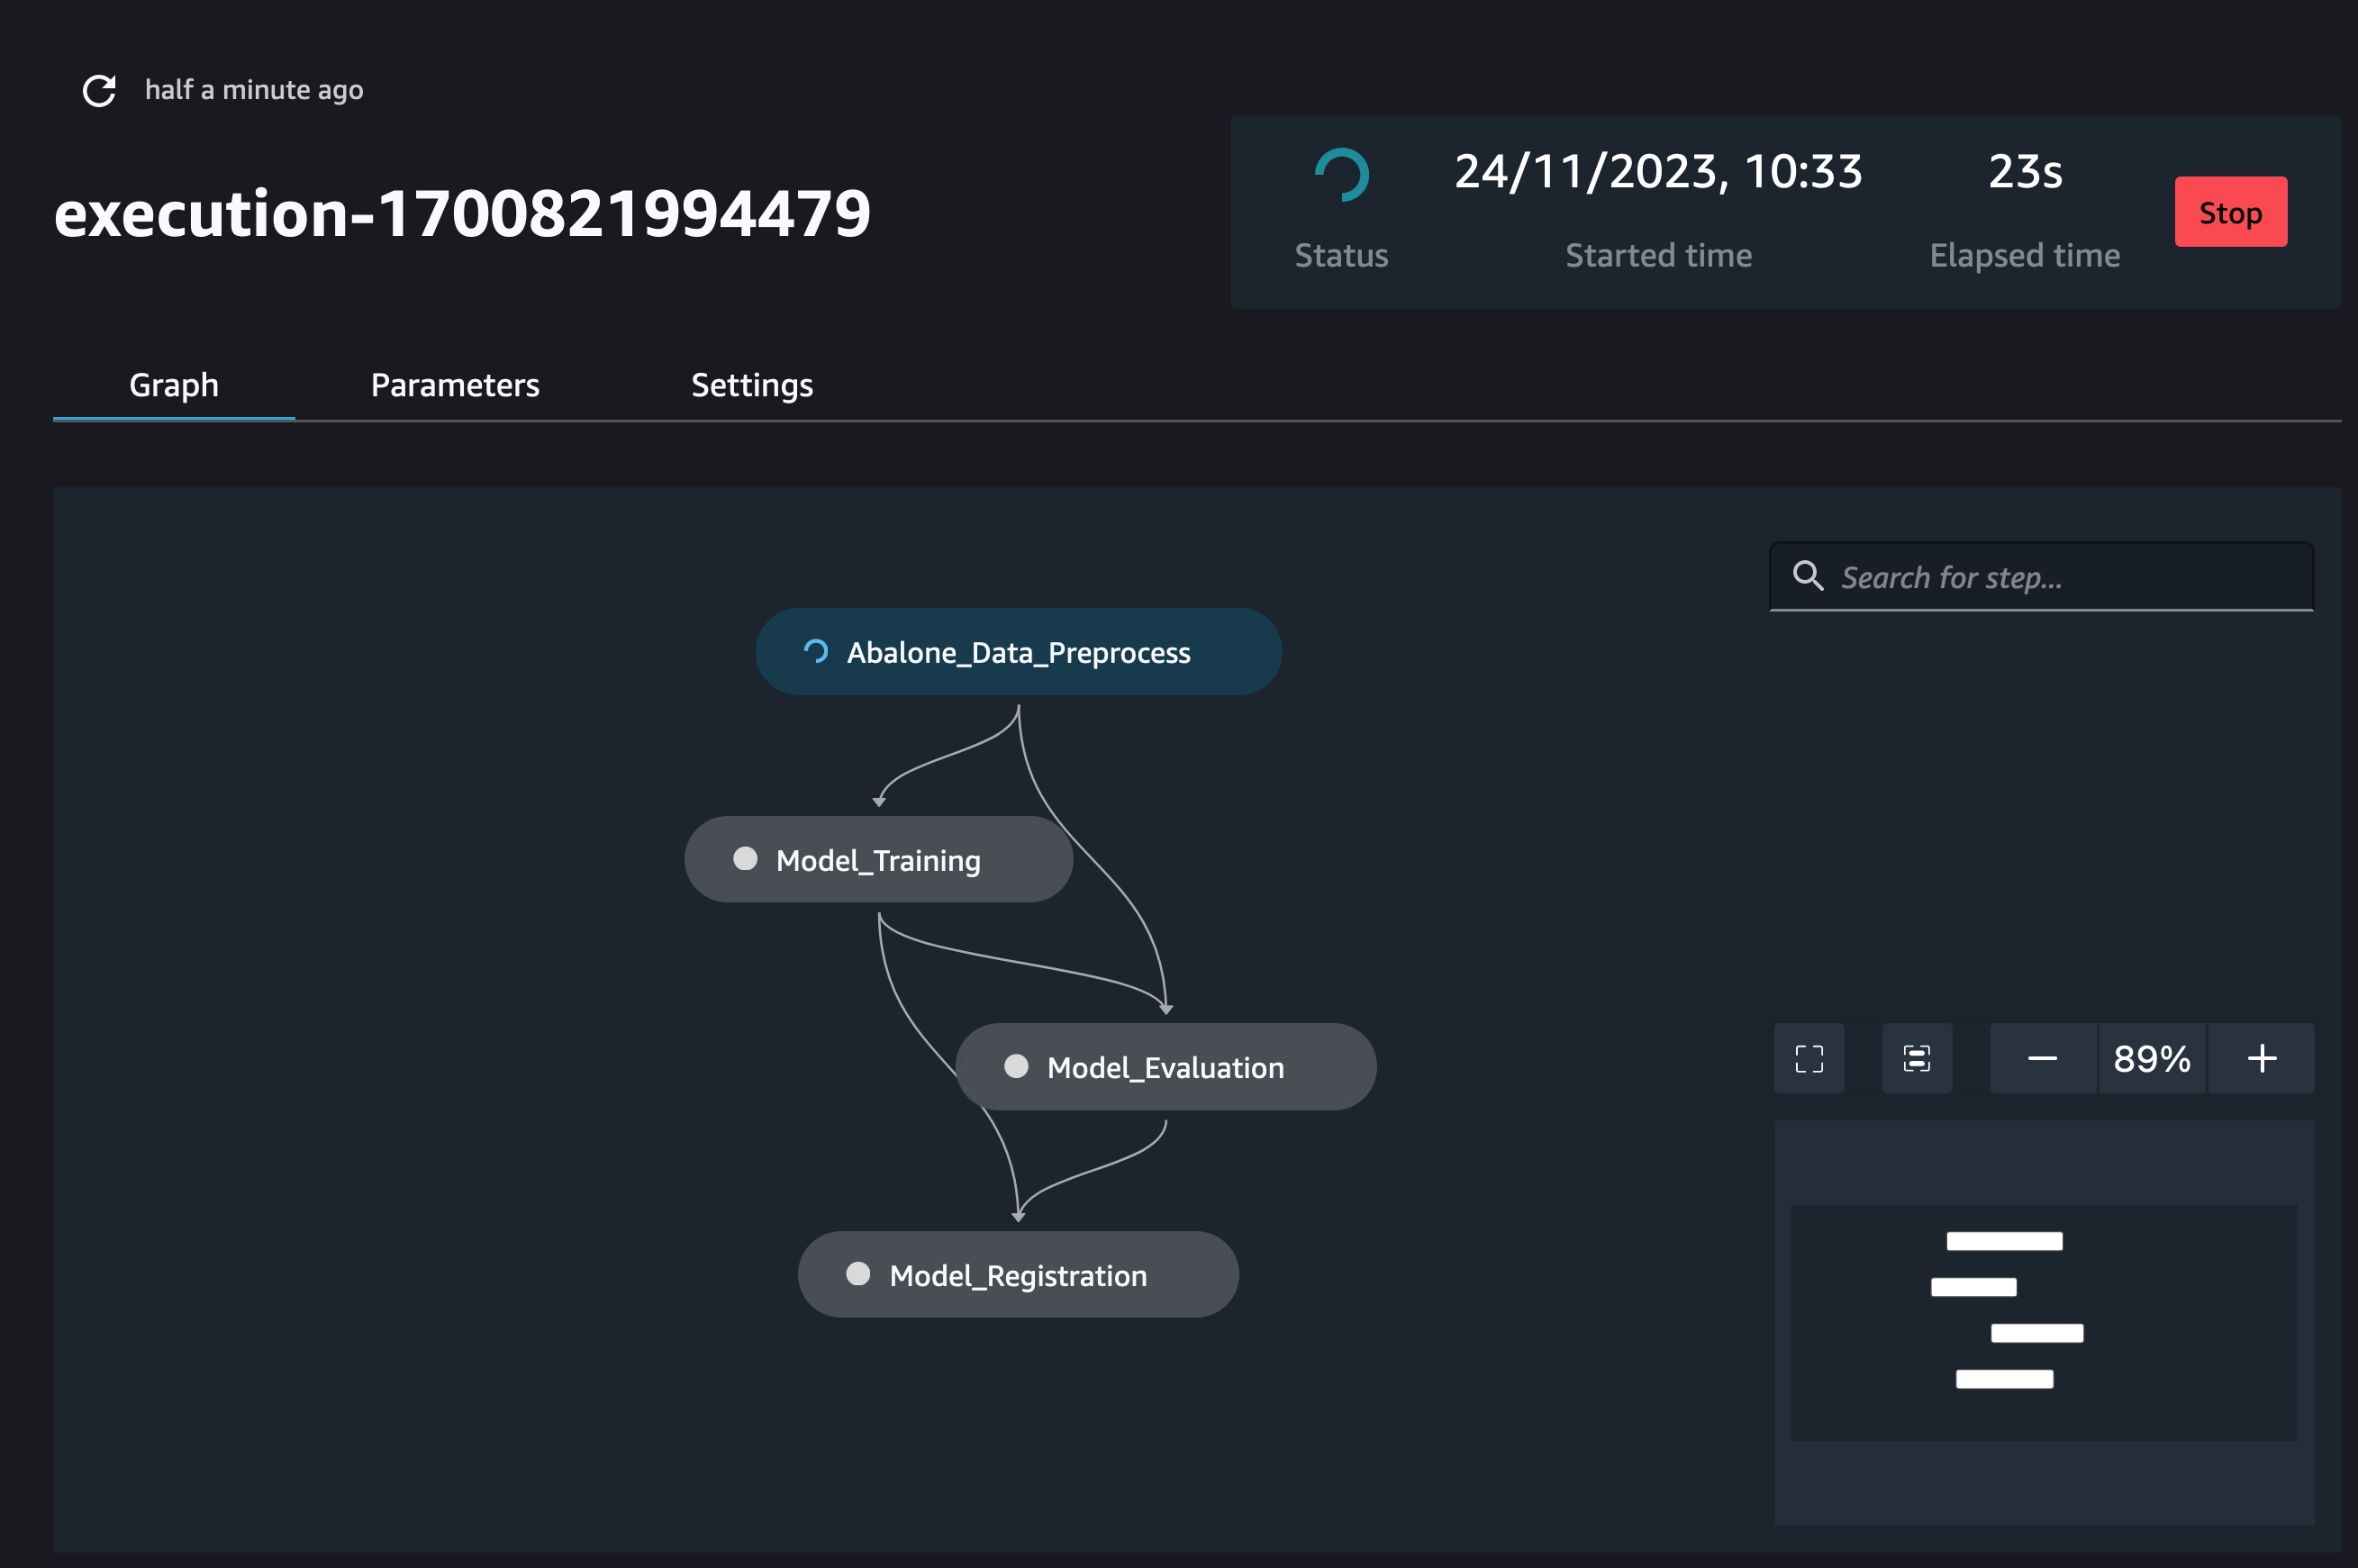



In [ ]:
from IPython.display import HTML

# Show the pipeline link
display(
    HTML('<b>See <a target="top" href="https://studio-{}.studio.{}.sagemaker.aws/pipelines/{}/graph">the pipeline</a> in the Studio UI</b>'.format(
            domain_id, region, sm_pipeline_name))
)

## Coding Challenge

Modify the following code to also keep track of the current git commit hash. **Suggestion**:
1. use the GitPython library to find the latest commit hash
2. modify the [`pipeline.py`](pipeline.py) file to accept a new argument and log the value to mlflow